# Download data

In [2]:
import os
import zipfile
import kaggle
# use kaggle api to download the data or manully download the data urself
## ! Kaggle competitions download -c "jane-street-real-time-market-data-forecasting" 

# make the directory to be "data/jane-street-real-time-market-data-forecasting" and extract file there u f the code dont work do it manually
## os.makedirs("data/jane-street-real-time-market-data-forecasting", exist_ok=True) # create directory for jane-street-real-time-market-data-forecasting-housing
## !unzip jane-street-real-time-market-data-forecasting.zip -d data/jane-street-real-time-market-data-forecasting/

# Kaggle Competition 

In [3]:
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [4]:
# function for import the data .parquet to pandas dataframe
def import_data(i): # the data have 10 partiton 0 to 9
    file_path = f"data/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet"
    df = pd.read_parquet(file_path)
    print(f"import train data part {i}")
    return df

In [5]:
# test/example of the import fuction
# train0 = download_data(0)
train_data = import_data(9) # there are just more data in the train.parquet partition 9

import train data part 9


In [6]:
# import test data 
file_path  = f"data/jane-street-real-time-market-data-forecasting/test.parquet/date_id=0/part-0.parquet"
test_data = pd.read_parquet(file_path)

In [7]:
# import lag data
file_path  = f"data/jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet"
lag_data = pd.read_parquet(file_path)

# Data Preprocessing

## Data cleaning

In [8]:
# feature selection ## select every feature except 0-4 
feature_cols = [f"feature_{idx:02d}" for idx in range(79)]

#select target values
target_cols = ["responder_6"]

#select lag values
time_cols = ["date_id","time_id"]

# select the weight values
weight_cols = ["weight"]

## drop the other responder column

## respons to nan values

In [9]:
# remove the nan values
def replace_nan_with_mean_or_zero(column):
    mean_value = column.mean()
    if pd.notnull(mean_value):
        return column.fillna(mean_value)
    else:
        return column.fillna(0)

# try to create the final data with lag from sample

In [10]:
group_by = ["date_id", "symbol_id"]
lag_col = ["responder_6_lag_1"]
result = pd.merge(test_data, lag_data, on = group_by)
X_test = result[feature_cols + lag_col]
X_test = X_test.apply(replace_nan_with_mean_or_zero)

In [11]:
X_test.head()

,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6_lag_1
0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-1.305746
1,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.162801
2,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-1.574290
3,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.329152
4,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219856


# Create training data with lag

In [12]:
# Extract features and target, and add lagged target values
train_data['responder_6_lag_1'] = train_data.groupby(['symbol_id','time_id'])[target_cols].shift(1)
train_data = train_data.apply(replace_nan_with_mean_or_zero)
all_features_cols= feature_cols + ['responder_6_lag_1']

In [13]:
# Split the data into training and validation sets
max_date_id = train_data['date_id'].max()
num_val = 10
train_set = train_data[train_data['date_id'] < max_date_id - num_val]
val_set = train_data[train_data['date_id'] >= max_date_id - num_val]

# model

In [14]:
train_set[target_cols].min(), train_set[target_cols].max()

(responder_6   -5.0
 dtype: float32,
 responder_6    5.0
 dtype: float32)

In [91]:
from sklearn.preprocessing import MinMaxScaler

ScaleX = MinMaxScaler(feature_range=(-1,1)).fit(train_set[all_features_cols])
ScaleY = MinMaxScaler(feature_range=(-1,1)).fit(train_set[target_cols])
X_train = ScaleX.transform(train_set[all_features_cols])
y_train = ScaleY.transform(train_set[target_cols])
X_val = ScaleX.transform(val_set[all_features_cols])    
y_val = ScaleY.transform(val_set[target_cols])

In [92]:
y_train.min(), y_train.max()

(-1.0, 1.0)

In [93]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

sample_indices = np.random.RandomState(seed=42).choice(X_train.shape[0], 10000, replace=False)
X_sample = X_train[sample_indices]
y_sample = y_train[sample_indices]

param_grid = {
    'loss': ['squared_error', 'huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.00001,0.0001, 0.001, 0.01, 0.1],
    'max_iter': [1000, 2000, 4000, 8000],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5,1e-6],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 1],
    'random_state': [42]
}

SGDReg_CV =  SGDRegressor()
grid_search = GridSearchCV(SGDReg_CV, param_grid, cv=5, n_jobs=-1, scoring='r2')

# Fit the model
grid_search.fit(X_sample, y_sample)

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SGDRegressor(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'eta0': [0.01, 0.1, 1],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'loss': ['squared_error', 'huber'],
                         'max_iter': [1000, 2000, 4000, 8000],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'random_state': [42],
                         'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
             scoring='r2')

In [94]:
# Use the best parameters to train the final model
best_params = grid_search.best_params_

# Create a new pipeline with the best parameters
SGDReg = SGDRegressor(
        loss=best_params['loss'],
        penalty=best_params['penalty'],
        alpha=best_params['alpha'],
        max_iter=best_params['max_iter'],
        tol=best_params['tol'],
        learning_rate=best_params['learning_rate'],
        eta0=best_params['eta0']
    )

SGDReg.fit(X_train, y_train)

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.001, learning_rate='optimal', loss='huber', penalty='l1',
             tol=1e-05)

In [95]:
best_params

{'alpha': 0.001,
 'eta0': 0.01,
 'learning_rate': 'optimal',
 'loss': 'huber',
 'max_iter': 1000,
 'penalty': 'l1',
 'random_state': 42,
 'tol': 1e-05}

In [96]:
pred = SGDReg.predict(X_val)
pred_inverse = ScaleY.inverse_transform(pred.reshape(-1, 1))
r2 = r2_score(val_set[target_cols], pred_inverse, sample_weight=val_set[weight_cols])
print(f"R2 score: {r2:.6f}")

R2 score: -0.003118


In [97]:
pred_inverse.min(), pred_inverse.max()

(-0.035432001441878344, -0.035432001441878344)

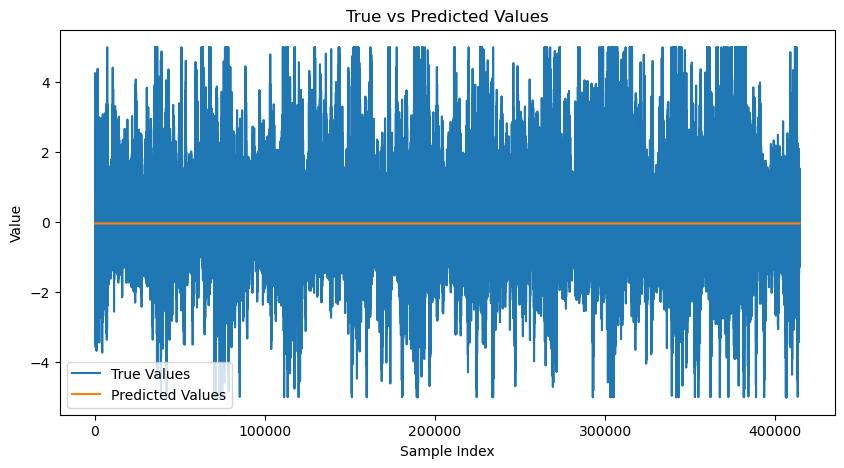

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(val_set[target_cols].reset_index(drop =True), label='True Values')
plt.plot(pred_inverse, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [99]:
def validate_n_fold(model,val_set,n_folds):
    global all_features_cols, target_cols, weight_cols, ScaleX, ScaleY
    batch_size = len(val_set)//n_folds
    X_val = ScaleX.transform(val_set[all_features_cols])    
    for i in range(0, len(val_set), batch_size):
        X_batch = X_val[i:i+batch_size]
        val_batch = val_set[i:i+batch_size]
        preds = model.predict(X_batch)
        pred_inverse = ScaleY.inverse_transform(preds.reshape(-1, 1))
        score1 = r2_score(val_batch[target_cols], pred_inverse ,sample_weight= val_batch[weight_cols])
        print(f'Batch {i//batch_size} r2_score: {score1:.6f}')

In [100]:
validate_n_fold(SGDReg, val_set, 10)

Batch 0 r2_score: -0.006986
Batch 1 r2_score: -0.000537
Batch 2 r2_score: -0.005085
Batch 3 r2_score: -0.003642
Batch 4 r2_score: -0.000642
Batch 5 r2_score: -0.006064
Batch 6 r2_score: -0.007132
Batch 7 r2_score: -0.002868
Batch 8 r2_score: -0.003158
Batch 9 r2_score: -0.000839
Batch 10 r2_score: -4.430380


# test with train data 8

In [101]:
test8 = import_data(8)
test8['responder_6_lag_1'] = test8.groupby(['symbol_id','time_id'])[target_cols].shift(1)
test8 = test8.apply(replace_nan_with_mean_or_zero)

import train data part 8


In [102]:
validate_n_fold(SGDReg, test8, 10)

Batch 0 r2_score: -0.002415
Batch 1 r2_score: -0.001029
Batch 2 r2_score: -0.001391
Batch 3 r2_score: -0.002052
Batch 4 r2_score: -0.003305
Batch 5 r2_score: -0.001285
Batch 6 r2_score: -0.002012
Batch 7 r2_score: -0.001599
Batch 8 r2_score: -0.003008
Batch 9 r2_score: -0.002660
Batch 10 r2_score: -4.851014


In [103]:
import joblib
# save
joblib.dump(SGDReg, "SDGReg_minmax_scale.pkl") 

['SDGReg_minmax_scale.pkl']